In [3]:
# Importing Dependencies
from cobra import Model, Reaction, Metabolite
import cobra.test
from cobra.flux_analysis import (single_gene_deletion, single_reaction_deletion)
import cobra
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import sklearn.metrics as skl_metrics
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import umap
from tqdm import tqdm

--------------------
# Individual Project
- Spectral Graph Theory Methods
- Investigating Change in Eigengap
- Investigating Change in Algebraic Connectivity
--------------------

In [218]:
def calculate_metrics(sbml_file, amat_csv, sheet_name):
    ## reading in SBML model to cobra
    model = cobra.io.read_sbml_model(sbml_file)
    ## generating metabolic model solution
    solution = model.optimize()
    obj_value = solution.objective_value
    deletion_results = single_reaction_deletion(model)
    deletion_results['ids'] = deletion_results['ids'].apply(lambda x: list(x)[0])
    # generating essectional reactions list
    essential_rxns = deletion_results[deletion_results['growth'] < (0.05 * obj_value)]['ids'].values
    ## reading in adjacency matrix
    df = pd.read_excel(amat_csv, sheet_name=sheet_name)
    adj_arr = df.to_numpy()
    g_nodes = np.char.strip(adj_arr[:, 0].astype('str'))
    adj_mat = adj_arr[:, 1:].astype('int')
    ## generating networkx graph objects
    g_basic = nx.convert_matrix.from_numpy_matrix(adj_mat, create_using=nx.DiGraph, parallel_edges=False)
    g_basic_undirected = nx.convert_matrix.from_numpy_matrix(adj_mat, parallel_edges=False)
    node_map = {k: v for (k, v) in zip(np.arange(len(g_nodes)), g_nodes)}
    g = nx.relabel_nodes(g_basic, node_map)
    g_u = nx.relabel_nodes(g_basic_undirected, node_map)
    ## calculating basic graph metrics
    # calculating clustering coefficients
    clustering_coeff = nx.algorithms.clustering(g)
    # calculating betweenness centrality
    bet_cent = nx.algorithms.centrality.betweenness_centrality(g, normalized=False)
    # calculating bridging centrality
    degree = nx.degree(g)
    bridge_cent = {}
    adj_g = g_u.adj
    for node in adj_g.keys():
        neigh_degree = 0
        node_degree = degree[node]
        for node_neigh in adj_g[node].keys():
            neigh_degree += 1/(degree[node_neigh])
        bridge_cent[node] = ((1/node_degree)/(neigh_degree))*bet_cent[node]
    ## generating df for centrality metrics
    gm_dict = {'node': g_nodes, 
     'bridge_cent': np.array(list(bridge_cent.values())),
     'clustering_coeff': np.array(list(clustering_coeff.values())), 
     'bet_cent': np.array(list(bet_cent.values())), 
     'degree': np.array(list(dict(degree).values()))}
    gm_df = pd.DataFrame(gm_dict) #graph metric dataframe
    # applying log transforms on centrality metrics
    gm_df['bridge_cent'] = gm_df['bridge_cent'].apply(np.log10)
    gm_df['bet_cent'] = gm_df['bet_cent'].apply(np.log10)
    gm_df['degree'] = gm_df['degree'].apply(np.log10)
    gm_df.loc[((gm_df['bet_cent'] < 0) & (gm_df['bridge_cent'] < 0)), ['bet_cent', 'bridge_cent']] = 0
    ## calculating spectral metrics for whole graph (base graph)
    ls_base = nx.laplacian_spectrum(g_u)
    ac_base = ls_base[1]
    dls_base, _ = np.linalg.eig(nx.directed_laplacian_matrix(g))
    dls_base =  np.sort(np.real(dls_base))
    dac_base = dls_base[1]
    eiggap_base = np.argmax(np.diff(ls_base))
    deiggap_base = np.argmax(np.diff(dls_base))
    ## Calculating spectral metrics for node removal
    dir_ac = []
    udir_ac = []
    dir_eiggap = []
    udir_eiggap = []
    node_names = []
    for node_del in tqdm(g_nodes):
        g = nx.relabel_nodes(g_basic, node_map)
        g_u = nx.relabel_nodes(g_basic_undirected, node_map)
        g.remove_node(node_del)
        g_u.remove_node(node_del)
        # undirected algebraic connectivity
        ls = nx.laplacian_spectrum(g_u)
        udir_ac.append(ls[1])
        # directed algebraic connectivity
        dls, _ = np.linalg.eig(nx.directed_laplacian_matrix(g))
        dls = np.sort(np.real(dls))
        dir_ac.append(dls[1])
        # undirected eigengap
        udir_eiggap.append(np.argmax(np.diff(ls)))
        # directed eigengap
        dir_eiggap.append(np.argmax(np.diff(dls)))
        node_names.append(node_del)
    # putting all metrics into pandas DataFrame
    dir_ac = np.array(dir_ac) - dac_base
    udir_ac = np.array(udir_ac) - ac_base
    dir_eiggap = np.array(dir_eiggap) - deiggap_base
    udir_eiggap = np.array(udir_eiggap) - eiggap_base
    metric_df = pd.DataFrame({'algebraic connectivity (directed)': dir_ac, 
                              'algebraic connectivity (undirected)': udir_ac, 
                              'eigen gap (directed)': dir_eiggap, 
                              'eigen gap (undirected)': udir_eiggap, 
                              'node': node_names})
    metric_df['essential'] = metric_df['node'].isin(list(essential_rxns))
    out_df = metric_df.merge(gm_df, left_on='node', right_on='node', how='inner')
    return metric_df


def generate_plots(dfs, names):
    for df, name in zip(dfs, names):
        df['organism name'] = name
    df = pd.concat(dfs, axis=0)
    df = df.loc[:, ['organism name', 'algebraic connectivity (directed)', 'eigen gap (directed)', 'essential']]
#     df = pd.melt(df, id_vars=['essential'], value_vars=['algebraic connectivity (directed)', 'eigen gap (directed)', 'organism name'], var_name='variable', value_name='value')
    g = sns.PairGrid(df, y_vars=['algebraic connectivity (directed)', 'eigen gap (directed)'], 
                     x_vars=['essential'], hue='organism name', aspect=2)
    g.map(sns.stripplot, jitter=1, alpha=0.25)
    g.add_legend()
    plt.show()
    return g


def test_stats_all(dfs, names):
    variables = np.array(['intercept', 'algebraic connectivity (directed)', 'eigen gap (directed)', 'interaction'])
    models = []
    p_vals = []
    coeffs = []
    lls = []
    name_list = []
    for df, name in list(zip(dfs, names)):
        glm, res = test_stats(df, name)
        models.append(glm)
        p_vals.append(res.pvalues.values)
        coeffs.append(res.params.values)
        name_list.append(np.array([name]*len(variables)))
    # generating pivot table for output
    variables = np.tile(variables, len(name_list))
    p_vals = np.hstack(p_vals)
    coeffs = np.hstack(coeffs)
    name_list = np.hstack(name_list)
    stats_df = pd.DataFrame({'p-value': p_vals, 'coefficient': coeffs, 'organism name': name_list, 'variable': variables})
    stats_pt = stats_df.pivot(index=['variable'], columns='organism name', values=['p-value', 'coefficient'])
    return stats_pt

def test_stats(df, name, verbose=False):
    if verbose == True:
        print('####################')
        print(name)
        print('####################')
    df['intercept'] = np.ones(len(df))
    df['interaction'] = df['algebraic connectivity (directed)']*df['eigen gap (directed)']
    variables = ['intercept', 'algebraic connectivity (directed)', 'eigen gap (directed)', 'interaction']
    X = df.loc[:, variables]
    y = df.loc[:, 'essential']
    glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
    res = glm_binom.fit()
    if verbose == True:
        print(res.summary())
    return glm_binom, res
    

# Running Analyses

In [198]:
ecoli_df = calculate_metrics('iJO1366.xml', 'metabolic_networks.xlsx', 0)
bsubtilis_df = calculate_metrics('iYO844.xml', 'metabolic_networks.xlsx', 1)
gmetallireducens_df = calculate_metrics('iAF987.xml', 'metabolic_networks.xlsx', 2)
kpneumoniae_df = calculate_metrics('iYL1228.xml', 'metabolic_networks.xlsx', 3)
scerevisiae_df = calculate_metrics('iMM904.xml', 'metabolic_networks.xlsx', 4)

# Generating Plots

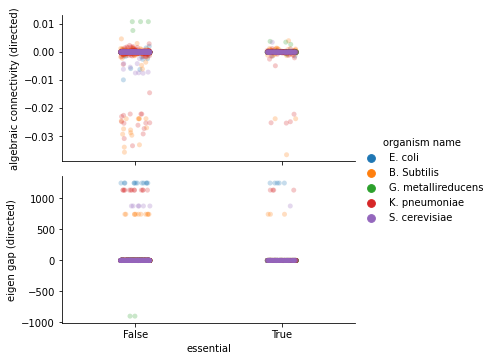

In [219]:
dfs_plot = [ecoli_df, bsubtilis_df, gmetallireducens_df, kpneumoniae_df, scerevisiae_df]
names_plot = ['E. coli', 'B. Subtilis', 'G. metallireducens', 'K. pneumoniae', 'S. cerevisiae']
graph = generate_plots(dfs_plot, names_plot)

# Running Stats Analysis

In [125]:
dfs_stats = [ecoli_df, bsubtilis_df, gmetallireducens_df, kpneumoniae_df, scerevisiae_df]
names_stats = ['E. coli', 'B. Subtilis', 'G. metallireducens', 'K. pneumoniae', 'S. cerevisiae']
stats_pts = test_stats_all(dfs_stats, names_stats)
stats_pts

/home/pgrosjean/anaconda3/envs/cobrapy/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/pgrosjean/anaconda3/envs/cobrapy/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:893: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/pgrosjean/anaconda3/envs/cobrapy/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


p-value                \
organism name                       B. Subtilis       E. coli   
variable                                                        
algebraic connectivity (directed)  4.355932e-02  5.889033e-01   
eigen gap (directed)               7.593596e-01  1.770288e-01   
interaction                        7.306646e-02  9.590677e-01   
intercept                          4.557889e-34  3.183597e-88   

                                                                    \
organism name                     G. metallireducens K. pneumoniae   
variable                                                             
algebraic connectivity (directed)           0.247865  9.147012e-01   
eigen gap (directed)                        0.256361  5.053487e-01   
interaction                                 0.247775  5.590993e-01   
intercept                                   0.517068  2.542723e-91   

                                                coefficient              \
organism name                     S. cerevisiae B. Subtilis     E. coli   
variable                                                                  
algebraic connectivity (directed)  1.135288e-01  379.951842  225.091566   
eigen gap (directed)               9.999995e-01   -0.001519    0.000663   
interaction                        9.999995e-01   -0.551895    0.023025   
intercept                          1.037433e-70   -1.028319   -1.441525   

                                                                    \
organism name                     G. metallireducens K. pneumoniae   
variable                                                             
algebraic connectivity (directed)      159336.240110     -7.903579   
eigen gap (directed)                        1.109960      0.003314   
interaction                            159366.620848      0.123772   
intercept                                   0.637623     -1.646663   

                                                 
organism name                     S. cerevisiae  
variable                                         
algebraic connectivity (directed)  11255.310483  
eigen gap (directed)                   0.043890  
interaction                            8.163885  
intercept                             -1.643615

In [18]:
# saving all information to csvs
ecoli_df.to_csv('ecoli.csv')
bsubtilis_df.to_csv('bsubtilis.csv')
gmetallireducens_df.to_csv('gmetallireducens.csv')
kpneumoniae_df.to_csv('kpneumoniae.csv')
scerevisiae_df.to_csv('scerevisiae.csv')